<a href="https://colab.research.google.com/github/arjan-hada/rosetta/blob/main/Rosetta_ddG_calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Protein mutational free energy (ΔΔG) prediction: Application to Rep68 origin binding domain

Accurately predicting thermodynamic consequences of a mutation is a crucial step in the world of protein engineering and design. In this notebook, we'll go through the process of estimating ΔΔG, a key metric for predicting changes in free energy due to amino acid substitutions. This metric has proven to be an effective predictor, helping us determine whether a point mutation will have a favorable impact on protein stability.

As an example, we will examine mutations in the AAV-2 Rep origin binding domain (OBD) 1-208.

Goals:

- Set up protein
- Compute the ∆∆G of mutation
- Visualize the model in Py3DMOL

## Background information on Rep68 OBD

The origin-binding domain (OBD) contains three separate DNA binding motifs that are important for AAV genome replication (attached image from [Santosh et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7736791/))
 - a) motif that participate in specific recognition of GCTC repeats in Rep binding element (RBE),
 - b) motif that interact with single stranded DNA stem (RBE'), and
 - c) motif that interact with terminal resolution site (trs).

Using deep mutational scanning experiment a paper published in 2023 from George M. Church lab found that the majority of beneficial substitutions that enhance AAV2 production clustered in the origin-binding domain ([Nina et al. , 2023](https://elifesciences.org/reviewed-preprints/87730v1)).

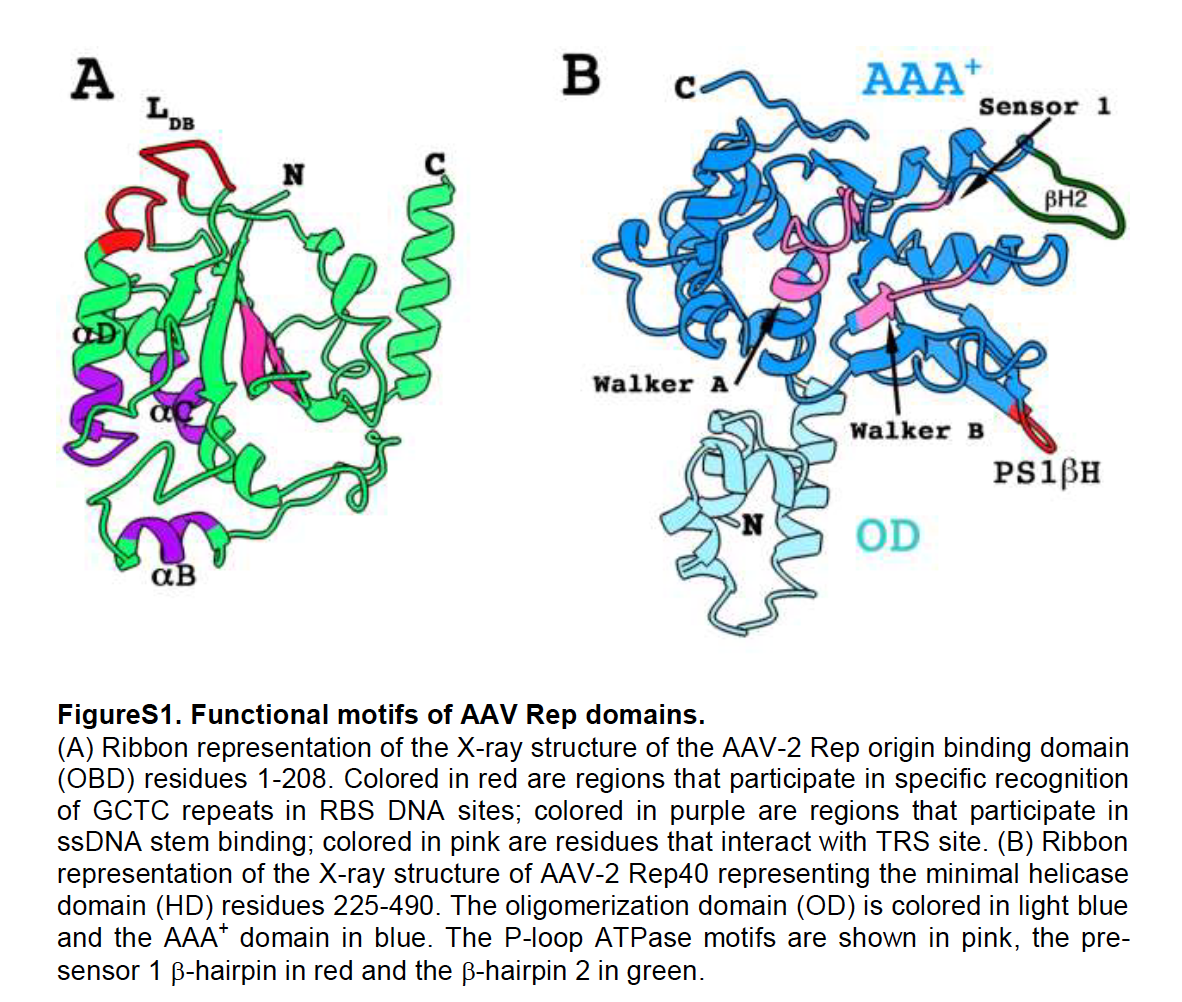

In [50]:
# attach image

from IPython.display import Image
Image(filename='images/AAV_rep_domain_Santosh_etal_suppl1.png', width=512)

#Image reference: [Santosh et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7736791/)

## Iniialization and setup

In [1]:
!pip install pyrosettacolabsetup &> /dev/null
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()
from pyrosetta import *
init()

Mounted at /content/google_drive
Looking for compatible PyRosetta wheel file at google-drive/PyRosetta/colab.bin//wheels...
Found compatible wheel: /content/google_drive/MyDrive/PyRosetta/colab.bin/wheels//content/google_drive/MyDrive/PyRosetta/colab.bin/wheels/pyrosetta-2024.1+release.00b79147e63-cp310-cp310-linux_x86_64.whl


PyRosetta-4 2023 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r366 2024.01+release.00b79147e63 00b79147e63be743438188f93a3f069ca75106d6 http://www.pyrosetta.org 2023-12-25T16:35:48
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.10/dist-packages/pyrosetta/database
basic.random.init_ra

In [2]:
!pip install biopython py3Dmol -U kaleido &> /dev/null

In [3]:
import glob
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
import os
import pyrosetta.distributed
import pyrosetta.distributed.io as io
import pyrosetta.distributed.viewer as viewer
import sys

## Load PDB file

Load the protein of interest. Here, we will use Adeno-Associated Virus Origin Binding Domain (OBD) in complex with single-stranded DNA from the inverted terminal repeat hairpin (PDB 6XB8).

In [4]:
import requests

def download_pdb(pdb_id, destination_folder="."):
    """
    Downloads a PDB file from the PDB website and saves it to the specified destination folder.
    """
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)

    if response.status_code == 200:
        # Save the PDB file to the destination folder
        file_path = f"{destination_folder}/{pdb_id}.pdb"
        with open(file_path, "w") as pdb_file:
            pdb_file.write(response.text)
        print(f"PDB file {pdb_id}.pdb downloaded successfully.")
    else:
        print(f"Failed to download PDB file for {pdb_id}. Status code: {response.status_code}")

In [5]:
# Download pdb file
pdb_id_to_download = "6XB8"  # Replace with the desired PDB ID
!mkdir -p inputs
download_pdb(pdb_id_to_download, "inputs")

PDB file 6XB8.pdb downloaded successfully.


In [6]:
# Look at first 10 lines of pdb file
!head -n 10 inputs/6XB8.pdb

HEADER    VIRAL PROTEIN                           05-JUN-20   6XB8              
TITLE     ADENO-ASSOCIATED VIRUS ORIGIN BINDING DOMAIN IN COMPLEX WITH SSDNA    
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: PROTEIN REP68;                                             
COMPND   3 CHAIN: A, B, C, D;                                                   
COMPND   4 EC: 3.6.4.12;                                                        
COMPND   5 ENGINEERED: YES;                                                     
COMPND   6 MOL_ID: 2;                                                           
COMPND   7 MOLECULE: DNA (5'-D(*GP*CP*TP*CP*TP*T)-3');                          
COMPND   8 CHAIN: E, F;                                                         


In [7]:
# Create a cleaned pdb file that only include the ATOM lines from the PDB file.
from pyrosetta.toolbox import cleanATOM
cleanATOM("inputs/6XB8.pdb")

In [8]:
# Look at first 10 lines of cleaned pdb file
!head -n 10 inputs/6XB8.clean.pdb

ATOM      1  N   MET A   1      38.003 -27.759  42.049  1.00 97.15           N  
ATOM      2  CA  MET A   1      39.237 -27.142  42.524  1.00 98.09           C  
ATOM      3  C   MET A   1      40.148 -26.730  41.371  1.00 96.00           C  
ATOM      4  O   MET A   1      40.258 -27.449  40.373  1.00101.95           O  
ATOM      5  CB  MET A   1      39.981 -28.091  43.466  1.00 97.38           C  
ATOM      6  CG  MET A   1      39.410 -28.142  44.880  1.00102.95           C  
ATOM      7  SD  MET A   1      39.450 -26.538  45.725  1.00106.65           S  
ATOM      8  CE  MET A   1      37.820 -26.489  46.478  1.00102.76           C  
ATOM      9  N   PRO A   2      40.795 -25.573  41.509  1.00 89.92           N  
ATOM     10  CA  PRO A   2      41.680 -25.073  40.456  1.00 82.33           C  


In [9]:
# Pose class includes various types of information that describe a structure
pose = pose_from_pdb("inputs/6XB8.pdb")
pose_clean = pose_from_pdb("inputs/6XB8.clean.pdb")

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 985 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.989047 seconds.
core.import_pose.import_pose: File 'inputs/6XB8.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 33
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 33
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 33
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 33
core.conformation.Conf

## Exploratory Data Analysis

In [10]:
# look at the sequence
pose.sequence()

'MPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKEZMPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQZMPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKENZMPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVZgctcttctct'

In [11]:
# look at the sequence of cleaned pdb file
pose_clean.sequence()

'MPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKEMPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQMPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKENMPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVgctcttctct'

In [12]:
print(pose.total_residue())
print(pose_clean.total_residue())

821
817


**What are the differences between uncleaned and cleaned pdb sequences?**

In [13]:
import difflib

def find_difference_difflib(str1, str2):
    d = difflib.Differ()
    diff = list(d.compare(str1, str2))
    return '|'.join(diff)

In [14]:
# Differences between uncleaned and cleaned sequences
find_difference_difflib(pose.sequence(),
                        pose_clean.sequence())

'  M|  P|  G|  F|  Y|  E|  I|  V|  I|  K|  V|  P|  S|  D|  L|  D|  E|  H|  L|  P|  G|  I|  S|  D|  S|  F|  V|  N|  W|  V|  A|  E|  K|  E|  W|  E|  L|  P|  P|  D|  S|  D|  M|  D|  L|  N|  L|  I|  E|  Q|  A|  P|  L|  T|  V|  A|  E|  K|  L|  Q|  R|  D|  F|  L|  T|  E|  W|  R|  R|  V|  S|  K|  A|  P|  E|  A|  L|  F|  F|  V|  Q|  F|  E|  K|  G|  E|  S|  Y|  F|  H|  M|  H|  V|  L|  V|  E|  T|  T|  G|  V|  K|  S|  M|  V|  L|  G|  R|  F|  L|  S|  Q|  I|  R|  E|  K|  L|  I|  Q|  R|  I|  Y|  R|  G|  I|  E|  P|  T|  L|  P|  N|  W|  F|  A|  V|  T|  K|  T|  R|  N|  G|  A|  G|  G|  G|  N|  K|  V|  V|  D|  E|  S|  Y|  I|  P|  N|  Y|  L|  L|  P|  K|  T|  Q|  P|  E|  L|  Q|  W|  A|  W|  T|  N|  M|  E|  Q|  Y|  L|  S|  A|  C|  L|  N|  L|  T|  E|  R|  K|  R|  L|  V|  A|  Q|  H|  L|  T|  H|  V|  S|  Q|  T|  Q|  E|  Q|  N|  K|  E|- Z|  M|  P|  G|  F|  Y|  E|  I|  V|  I|  K|  V|  P|  S|  D|  L|  D|  E|  H|  L|  P|  G|  I|  S|  D|  S|  F|  V|  N|  W|  V|  A|  E|  K|  E|  W|  E|  L|  P|  P|  D|  S|  D|  M|  D

In [15]:
# non-canonical amino acids and hetatms are spelled out more explicitly now
pose.annotated_sequence()

'M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKE[GLU:CtermProteinFull]Z[ZN]M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQ[GLN:CtermProteinFull]Z[ZN]M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKEN[ASN:CtermProteinFull]Z[ZN]M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHV[VAL:CtermProteinFull]Z

In [16]:
# non-canonical amino acids and hetero atoms (`hetatms`) are spelled out more explicitly now
pose_clean.annotated_sequence()

'M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKE[GLU:CtermProteinFull]M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQ[GLN:CtermProteinFull]M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKEN[ASN:CtermProteinFull]M[MET:NtermProteinFull]PGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHV[VAL:CtermProteinFull]g[GUA:LowerDNA:V

In [17]:
# Iterate over atoms and identify heteroatoms
for residue_id in range(1, pose.size() + 1):
    residue = pose.residue(residue_id)
    if residue.is_metal():
        print(f"HETATM found in residue {residue_id}: {residue.name3()}")

HETATM found in residue 206:  ZN
HETATM found in residue 407:  ZN
HETATM found in residue 614:  ZN
HETATM found in residue 811:  ZN


In [18]:
# Iterate over atoms and identify heteroatoms
for residue_id in range(1, pose_clean.size() + 1):
    residue = pose_clean.residue(residue_id)
    if residue.is_metal():
        print(f"HETATM found in residue {residue_id}: {residue.name3()}")

Looks like metals were removed in cleaned PDB file.

**How many chains and how many residues per chain?**

In [19]:
# Count the number of chains in the pose
print(pose_clean.num_chains())

6


In [20]:
# Access the information corresponding to the PDB file
print(pose_clean.pdb_info())

PDB file name: inputs/6XB8.clean.pdb
 Pose Range  Chain    PDB Range  |   #Residues         #Atoms

0001 -- 0205    A 0001  -- 0205  |   0205 residues;    03348 atoms
0206 -- 0405    B 0001  -- 0200  |   0200 residues;    03265 atoms
0406 -- 0611    C 0001  -- 0206  |   0206 residues;    03362 atoms
0612 -- 0807    D 0001  -- 0196  |   0196 residues;    03206 atoms
0808 -- 0813    E 0005  -- 0010  |   0006 residues;    00191 atoms
0814 -- 0817    F 0006  -- 0009  |   0004 residues;    00126 atoms
                           TOTAL |   0817 residues;    13498 atoms



In [21]:
for k, v in pyrosetta.rosetta.core.pose.conf2pdb_chain(pose_clean).items():
    print(f"Chain {v}: {pose_clean.chain_sequence(k)}")

Chain A: MPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKE
Chain B: MPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQ
Chain C: MPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKEN
Chain D: MPGFYEIVIKVPSDLDEHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDESYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHV
Chain E: gctctt
Chain F: ctct


**Visualization**

In [22]:
flags = """
-auto_setup_metals 1
-detect_disulf 1
"""
pyrosetta.distributed.init(flags)

In [23]:
view = viewer.init(pose_clean, window_size=(800, 600)) \
+ viewer.setStyle(radius=0) # layers the cartoon backbone and stick side-chain representation by default
view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## ΔΔG prediction details

The Cartesian ΔΔG method assesses the alteration in folding energy resulting from a mutation. This involves utilizing prepared initial structures and introducing the mutation to the specified target residue.

Rosetta protocols designed for predicting free energy changes due to mutations typically exhibit three key features:
(i) The choice of sampling method employed to create the structural ensemble.
(ii) The energy function utilized to quantify the free energy linked with each structure.
(iii) The extent of structural flexibility permitted to accommodate the introduced mutation.

Below is the description of cartddg2020 protocol from [Frenz et al., 2020](https://www.frontiersin.org/articles/10.3389/fbioe.2020.558247/full) paper:


>- **Step 0: Strip structures to only the chain in which the mutation occurs**

>- **Step 1: Relax starting model 20 times**

>Rosetta local refinement, consisting of alternating cycles of side chain packing and all atom minimization (“Relax”), is performed 20 times on the chain of interest and model with the lowest Rosetta energy is selected as input. This is performed without all atom constraints and in Cartesian space, not torsional space. This step energetically relaxes the input structure to generate an
ensemble of relaxed conformations, which is followed by the selection
of the most suitable one.

>- **Step 2 and step 3: Mutate target residue and repack**

>A sampling in the Cartesian space (as opposed to internal dihedrals sampling) is carried out, allowing small local backbone movements in a three-residue window around the mutation site, together with side-chains movements within a 6 Å radius from the mutation site. Additional fragment based sampling around mutations involving proline is performed to address changes in the backbone resulting from mutations to and from proline. By default 30 fragments of 5 residues in length, centered on the mutation, are sampled and the best scoring structure is carried forward for analysis. Cartesian sampler system is used for minimization.

>- **Step 4: Minimize target residue and its neighbors**

>After repacking the mutated residue, the side chain atoms of residues within 6 Å
of the target residue, and the side chain and backbone atoms of sequence-adjacent residues are minimized in Cartesian space.

>Step 3 and 4 are performed on starting structure without mutation to calculate baseline energy

>- **Repeat Step 2 - Step 4 until convergence or max of 5 times**

>The process is performed until convergence or max of 5 times for both the mutant and the wild type sequence. The lowest score must converge to within 1 Rosetta Energy Unit, or take the best of 5 models, whichever comes first. In either case the lowest, not the average, energy is used.



## ΔΔG prediction implementation

### Keep one chain for mutagenesis

In [24]:
#chC = pyrosetta.rosetta.core.select.residue_selector.ChainSelector("C")

In [25]:
# Unix command to select and keep one chain of pdb file
!grep '^ATOM\|^HETATM' inputs/6XB8.clean.pdb | awk '$5 == "C"' > inputs/6XB8.clean.chainC.pdb

This command does the following:

- `grep '^ATOM\|^HETATM' your_protein.pdb`: Filters lines that start with "ATOM" or "HETATM," which are the standard atomic coordinate records in a PDB file.

- `awk '$5 == "C"'`: Selects lines where the fifth column (chain identifier) is equal to "A".

- `> single_chain_protein.pdb`: Redirects the output to a new file named single_chain_protein.pdb.

In [26]:
!head -n 10 inputs/6XB8.clean.chainC.pdb

ATOM   3266  N   MET C   1      40.221  26.721  50.384  1.00107.59           N  
ATOM   3267  CA  MET C   1      40.412  26.755  48.937  1.00102.73           C  
ATOM   3268  C   MET C   1      41.261  25.568  48.462  1.00100.06           C  
ATOM   3269  O   MET C   1      42.412  25.417  48.879  1.00110.30           O  
ATOM   3270  CB  MET C   1      41.063  28.080  48.495  1.00106.58           C  
ATOM   3271  CG  MET C   1      42.318  28.523  49.274  1.00109.62           C  
ATOM   3272  SD  MET C   1      42.038  29.473  50.797  1.00105.54           S  
ATOM   3273  CE  MET C   1      41.201  30.923  50.152  1.00101.14           C  
ATOM   3274  N   PRO C   2      40.689  24.719  47.584  1.00 91.82           N  
ATOM   3275  CA  PRO C   2      41.417  23.521  47.133  1.00 83.72           C  


In [27]:
!tail -n 10 inputs/6XB8.clean.chainC.pdb

ATOM   4922  OE2 GLU C 205      35.213  48.592  54.515  1.00101.16           O  
ATOM   4923  N   ASN C 206      40.808  52.439  54.562  1.00115.65           N  
ATOM   4924  CA  ASN C 206      42.239  52.290  54.860  1.00115.03           C  
ATOM   4925  C   ASN C 206      42.792  50.862  54.864  1.00111.27           C  
ATOM   4926  O   ASN C 206      43.251  50.375  55.899  1.00114.30           O  
ATOM   4927  CB  ASN C 206      42.520  52.952  56.210  1.00118.13           C  
ATOM   4928  CG  ASN C 206      42.165  54.428  56.207  1.00121.97           C  
ATOM   4929  OD1 ASN C 206      41.342  54.873  55.401  1.00122.27           O  
ATOM   4930  ND2 ASN C 206      42.769  55.191  57.114  1.00123.17           N  
ATOM   4931  OXT ASN C 206      42.797  50.169  53.842  1.00104.36           O  


In [28]:
# import pose
pose_clean_chC = pose_from_pdb( "inputs/6XB8.clean.chainC.pdb")

core.import_pose.import_pose: File 'inputs/6XB8.clean.chainC.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 32
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 33
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 33
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 33
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 33
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 34
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 34
core.conformation.Conformation:

In [29]:
print(pose_clean_chC.total_residue())

206


In [30]:
view = viewer.init(pose_clean_chC, window_size=(800, 600)) \
+ viewer.setStyle(radius=0) # layers the cartoon backbone and stick side-chain representation by default
view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [31]:
# Download that pdb file
from google.colab import files
files.download("inputs/6XB8.clean.chainC.pdb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### FastRelax

Properly relaxing a structure is crucial in design with Rosetta. A non relaxed structure may not overcome bad global energy well and therefore skew the free energy prediction.

A FastRelax() is used to relax the structure. The goal is to put the structure in its lowest energy state.

In [32]:
# Initialization
cartesianrelaxprep_flags = """
-default_max_cycles 200  \
-missing_density_to_jump  \
-ignore_zero_occupancy false \
-fa_max_dis 9
"""

init(cartesianrelaxprep_flags)

PyRosetta-4 2023 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r366 2024.01+release.00b79147e63 00b79147e63be743438188f93a3f069ca75106d6 http://www.pyrosetta.org 2023-12-25T16:35:48
core.init: command: PyRosetta -default_max_cycles 200 -missing_density_to_jump -ignore_zero_occupancy false -fa_max_dis 9 -database /usr/local/lib/python3.10/dist-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-709079087 seed_offset=0 real_seed=-709079087
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-709079087 RG_type=mt19937


In [33]:
# Copy pose
pose_clean_chC_orign = pose_clean_chC.clone()

In [34]:
# Score function
scorefxn = create_score_function("ref2015_cart")

core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 9)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 9)
core.scoring.etable: Finished calculating energy tables.
core.energy_methods.CartesianBondedEnergy: Initializing IdealParametersDatabase with default Ks=300 , 80 , 80 , 10 , 80
basic.io.database: Database file opened: scoring/score_functions/bondlength_bondangle/default-lengths.txt
core.energy_methods.CartesianBondedEnergy: Read 759 bb-independent lengths.
basic.io.database: Database file opened: scoring/score_functions/bondlength_bondangle/default-angles.txt
core.energy_methods.CartesianBondedEnergy: Read 1434 bb-independent angles.
basic.io.database: Database file opened: scoring/score_functions/bondlength_bondangle/default-torsions.txt
core.energy_methods.CartesianBondedEnergy: Read 1 bb

In [35]:
# Score before relaxation
print(f"original score: {scorefxn(pose_clean_chC_orign)}")

core.energy_methods.CartesianBondedEnergy: Creating new peptide-bonded energy container (206)
original score: 834.4468341759881


In [37]:
# Apply cartesianrelaxprep protocol on pose
parser = pyrosetta.rosetta.protocols.rosetta_scripts.RosettaScriptsParser()
protocol = parser.generate_mover("scripts/cartesianrelaxprep.xml")

if not os.getenv("DEBUG"):
    %time protocol.apply(pose_clean_chC)

protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Generating XML Schema for rosetta_scripts...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: ...done
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Initializing schema validator...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: ...done
protocols.rosetta_scripts.RosettaScriptsParser: ...done
protocols.rosetta_scripts.RosettaScriptsParser: Parsed script:
<ROSETTASCRIPTS>
	<SCOREFXNS>
		<ScoreFunction name="fullatom" symmetric="0" weights="ref2015_cart"/>
	</SCOREFXNS>
	<MOVERS>
		<FastRelax cartesian="1" name="fastrelax" repeats="20" scorefxn="fullatom"/>
	</MOVERS>
	<PROTOCOLS>
		<Add mover="fastrelax"/>
	</PROTOCOLS>
	<OUTPUT scorefxn="fullatom"/>
</ROSETTASCRIPTS>
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep

Alternate way of doing relaxation
```
relax = pyrosetta.rosetta.protocols.relax.FastRelax(scorefxn_in=scorefxn, standard_repeats=20)
relax.cartesian(True)
relax.min_type("lbfgs_armijo_nonmonotone") # Cartisian scorefunction

if not os.getenv("DEBUG"):
    relax.apply(pose_clean_chC)
```

What is the delta total_score from pose to relaxed pose?

In [38]:
print(f"relaxed score:  {scorefxn(pose_clean_chC)}")
print(f"original score: {scorefxn(pose_clean_chC_orign)}")
delta = scorefxn(pose_clean_chC) - scorefxn(pose_clean_chC_orign)
print(f"delta:          {delta}")

relaxed score:  -1055.6801392036264
original score: 834.4468341759881
delta:          -1890.1269733796144


By how many Angstroms RMSD did the backbone Cα atoms move?

In [39]:
pyrosetta.rosetta.core.scoring.CA_rmsd(pose_clean_chC_orign,
                                       pose_clean_chC)

0.9807520508766174

In [40]:
pose_clean_chC.dump_pdb('inputs/6XB8.clean.chC.relaxed.pdb')

True

In [41]:
# Download that pdb file
from google.colab import files
files.download("inputs/6XB8.clean.chC.relaxed.pdb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### cartesian_ddG

Each protocol takes as inputs the three-dimensional
(3D) structure of the protein of interest and a list of mutations to be performed, finally returning the predicted free energy changes associated with each input mutation. We will take the lowest energy structure and allow all possible mutations for the entire structure.



**First input - relaxed pdb file**

In [42]:
# Load the relaxed pose
pose_clean_chC_relax = pose_from_pdb("inputs/6XB8.clean.chC.relaxed.pdb")

core.import_pose.import_pose: File 'inputs/6XB8.clean.chC.relaxed.pdb' automatically determined to be of type PDB


In [43]:
protein_sequence = pose_clean_chC_relax.sequence()

**Second input - mutfile**

In [44]:
!python scripts/generate_mutfile_ddgscan.py \
    --protein_sequence $protein_sequence \
    --output_mutfile inputs/6XB8_chC_mutfile.mut

Mutfile generated: inputs/6XB8_chC_mutfile.mut


In [45]:
!head -n 10 inputs/6XB8_chC_mutfile.mut

total 4120
1
M 1 A
1
M 1 C
1
M 1 D
1
M 1 E
1


**Run**

This is the command we used for ddG calculation (cartddg2020):
```
#!/bin/bash
cartesian_ddg\
    -database $ROSETTA3_DB\
    -s ${input.pdb}\
    -ddg::iterations 5\
    -ddg::score_cutoff 1.0\
    -ddg::dump_pdbs false\
    -ddg::bbnbrs 1\
    -score:weights ref2015_cart\
    -ddg::mut_file ${mutfile.mut}\
    -ddg:frag_nbrs 2\
    -ignore_zero_occupancy false\
    -missing_density_to_jump \
    -ddg:flex_bb false\
    -ddg::force_iterations false\
    -fa_max_dis 9.0\
    -ddg::json true\
    -ddg:legacy false
```

### Analysis of ΔΔG score

In [46]:
import json

# Load JSON data from a file
with open('6XB8_chC_mutfile.json', 'r') as file:
    data = json.load(file)

In [47]:
import pandas as pd
dg_df = pd.DataFrame()
dg_df['wildtype']= [str(data[i]['mutations'][0]['wt']) +
                     str(data[i]['mutations'][0]['pos'])
                     for i in range(len(data))]
dg_df['mutation'] = [data[i]['mutations'][0]['mut'] for i in range(len(data))]
dg_df['total_score'] = [data[i]['scores']['total'] for i in range(len(data))]
dg_df['mutant'] = dg_df['wildtype'] + dg_df['mutation']

In [48]:
ddg_df = dg_df.groupby('mutant', sort=False, as_index=False).min()
ddg_df['ddG'] = ddg_df['total_score'] - ddg_df['total_score'][0]
ddg_df

mutant wildtype mutation  total_score        ddG
0       M1M       M1        M -1069.308017   0.000000
1       M1A       M1        A -1063.700008   5.608010
2       M1C       M1        C -1065.421870   3.886147
3       M1D       M1        D -1057.611268  11.696750
4       M1E       M1        E -1057.167393  12.140624
...     ...      ...      ...          ...        ...
4115  N206S     N206        S -1063.331743   5.976274
4116  N206T     N206        T -1062.195721   7.112296
4117  N206V     N206        V -1061.820308   7.487710
4118  N206W     N206        W -1060.859162   8.448855
4119  N206Y     N206        Y -1062.506106   6.801912

[4120 rows x 5 columns]

In [49]:
# Long to wide format conversion for plotting heatmap
ddg_df_wide = ddg_df.pivot_table(index='mutation',
                                 columns='wildtype',
                                 values='ddG',
                                 sort=False)

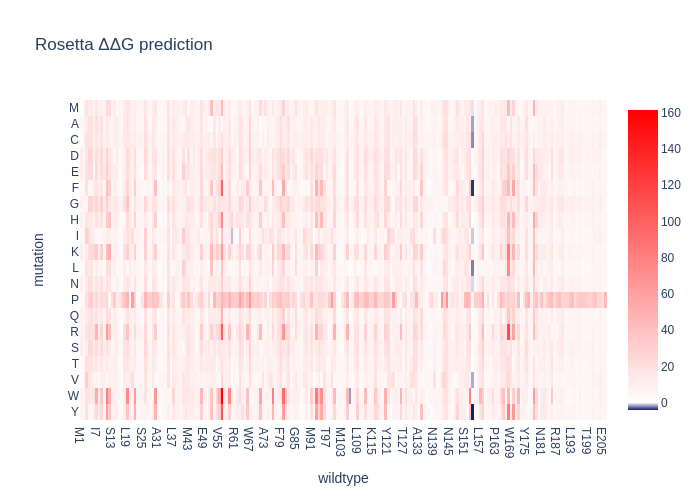

In [50]:
from scripts.create_heatmap import create_heatmap
create_heatmap(ddg_df_wide,
               title='Rosetta ΔΔG prediction',
               plot_interactive=False)

When we look at ΔΔG results, they usually fall into three buckets :
- 1) If **ΔΔG is greater than 0.5**, it means the mutation could make things unstable. Proteins are generally pretty stable, so most mutations will fall into this category or be close to zero. It's usually best to steer clear of these mutations during design.
- 2) When **ΔΔG is between 0.5 and -0.5**, it's considered pretty much neutral. These mutations are within the noise range, so they're okay to include in design if we're looking for more neutral changes in the protein.
- 3) Now, if **ΔΔG is less than -0.5**, that's actually a good thing – it suggests the mutation could make the protein more stable. But hold on – there are a few things to consider:
    - a) If our model doesn't account for interacting molecules, a mutation that seems promising might not actually be a good idea.
    - b) Sometimes, a position might have lots of negative ΔΔGs because it evolved a destabilizing residue for its catalytic activity or to bind to another molecule, or for some other functionally relevant reason.
    - c) And remember, ΔΔG measures just one point mutation. Often, you need multiple mutations interacting together to see a big change in stability.

reference: https://cyrusbio.com/wp-content/uploads/Rosetta-cartesian-DDG-2019.pdf

How many substitutions in Rep68 OBD have ΔΔG less than -0.5 kcal/mol ?

In [51]:
ddg_df.loc[ddg_df['ddG'] < -0.5]

mutant wildtype mutation  total_score       ddG
1187   Q60I      Q60        I -1070.459329 -1.151311
2118  G106W     G106        W -1071.069830 -1.761813
3060  P154A     P154        A -1070.941562 -1.633545
3061  P154C     P154        C -1071.378085 -2.070067
3064  P154F     P154        F -1073.028544 -3.720526
3067  P154I     P154        I -1070.225825 -0.917807
3069  P154L     P154        L -1071.573120 -2.265103
3070  P154M     P154        M -1069.808166 -0.500149
3071  P154N     P154        N -1070.013470 -0.705452
3077  P154V     P154        V -1070.758693 -1.450676
3079  P154Y     P154        Y -1073.406430 -4.098413

In [52]:
import py3Dmol
view=py3Dmol.view(width=800, height=600)
view.addModel(open('inputs/6XB8.pdb', 'r').read(),'pdb')
view.zoomTo()
view.setBackgroundColor('white')
#Setting style for chain C
view.setStyle({'cartoon': {'color':'spectrum'}})
#Add a visualization style for mutable residues in chain C
view.addStyle({'chain':['A', 'B', 'C', 'D'],'resi':[60, 106, 154]},
              {'sphere':{'colorscheme':'skyblueCarbon'}})
#And we finally visualize the structures using the command below
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

These results can be used to guide design in order to stablize structure.